In [1]:
from pathlib import Path
import numpy as np
import pandas as pd


In [2]:
EXCEL_PATH = Path("comparative anlysis tool (4).xlsx")
SHEET = "Elasticty Model"

df = pd.read_excel(EXCEL_PATH, sheet_name=SHEET)
df = df[["Location","Baseline Price P0","Baseline Qty Q0","Elasticity (neg)"]]
df = df.dropna()
df = df[(df["Baseline Price P0"] > 0) & (df["Baseline Qty Q0"] >= 0)]
df.head()


,Location,Baseline Price P0,Baseline Qty Q0,Elasticity (neg)
0,Polin - Shelter,45.0,9.0,-0.5
1,A. Ramsey - Shelter,85.0,44.0,-0.5
2,Arsenal - Shelter,85.0,28.0,-0.5
4,Bel Aire - Shelter #1,85.0,33.0,-0.5
5,Bel Aire - Shelter #2/Pavilion,85.0,2.0,-0.5


In [3]:
df["b"] = -df["Elasticity (neg)"] * (df["Baseline Qty Q0"] / df["Baseline Price P0"])
df["a"] = df["Baseline Qty Q0"] + df["b"] * df["Baseline Price P0"]

df[["Location","a","b"]].head()


,Location,a,b
0,Polin - Shelter,13.5,0.100000
1,A. Ramsey - Shelter,66.0,0.258824
2,Arsenal - Shelter,42.0,0.164706
4,Bel Aire - Shelter #1,49.5,0.194118
5,Bel Aire - Shelter #2/Pavilion,3.0,0.011765


In [4]:
def predict_qty(a, b, price):
    return max(a - b*price, 0)

def revenue(a, b, price):
    return price * predict_qty(a,b,price)


In [5]:
import numpy as np

def optimize_price(row):
    p0 = row["Baseline Price P0"]
    a = row["a"]
    b = row["b"]
    
    prices = np.linspace(p0*0.5, p0*1.8, 200)
    revenues = [revenue(a,b,p) for p in prices]
    
    i = np.argmax(revenues)
    return prices[i], revenues[i]

df[["Optimal Price","Max Revenue"]] = df.apply(lambda r: pd.Series(optimize_price(r)), axis=1)

df["Baseline Revenue"] = df["Baseline Price P0"] * df["Baseline Qty Q0"]
df["Revenue Gain %"] = 100*(df["Max Revenue"] - df["Baseline Revenue"]) / df["Baseline Revenue"]

df.head()


,Location,Baseline Price P0,Baseline Qty Q0,Elasticity (neg),b,a,Optimal Price,Max Revenue,Baseline Revenue,Revenue Gain %
0,Polin - Shelter,45.0,9.0,-0.5,0.100000,13.5,67.477387,455.624949,405.0,12.499987
1,A. Ramsey - Shelter,85.0,44.0,-0.5,0.258824,66.0,127.457286,4207.499528,3740.0,12.499987
2,Arsenal - Shelter,85.0,28.0,-0.5,0.164706,42.0,127.457286,2677.499700,2380.0,12.499987
4,Bel Aire - Shelter #1,85.0,33.0,-0.5,0.194118,49.5,127.457286,3155.624646,2805.0,12.499987
5,Bel Aire - Shelter #2/Pavilion,85.0,2.0,-0.5,0.011765,3.0,127.457286,191.249979,170.0,12.499987


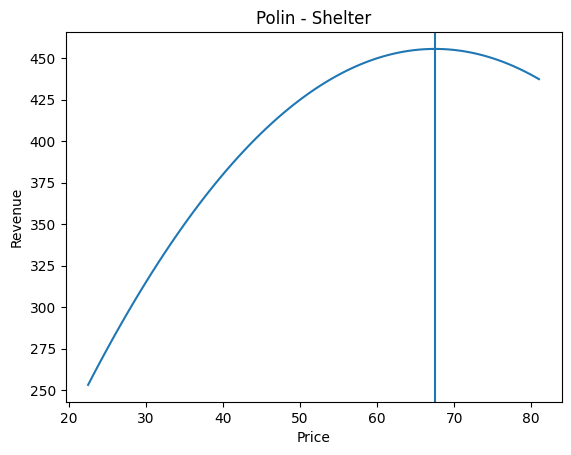

In [6]:
import matplotlib.pyplot as plt

row = df.iloc[0]

prices = np.linspace(row["Baseline Price P0"]*0.5, row["Baseline Price P0"]*1.8, 100)
revenues = [revenue(row["a"], row["b"], p) for p in prices]

plt.figure()
plt.plot(prices, revenues)
plt.axvline(row["Optimal Price"])
plt.title(row["Location"])
plt.xlabel("Price")
plt.ylabel("Revenue")
plt.show()


In [7]:
np.random.seed(42)

def simulate_elasticity(df, n=1000, mean=-0.5, std=0.15):
    sims = []

    for _ in range(n):
        df_sim = df.copy()
        df_sim["Elasticity Sim"] = np.random.normal(mean, std, len(df))
        df_sim["b_sim"] = -df_sim["Elasticity Sim"] * (df_sim["Baseline Qty Q0"] / df_sim["Baseline Price P0"])
        df_sim["a_sim"] = df_sim["Baseline Qty Q0"] + df_sim["b_sim"] * df_sim["Baseline Price P0"]

        df_sim["Revenue Sim"] = df_sim.apply(
            lambda r: revenue(r["a_sim"], r["b_sim"], r["Optimal Price"]), axis=1
        )

        sims.append(df_sim["Revenue Sim"].sum())

    return sims


In [8]:
sim_results = simulate_elasticity(df, n=1000)

print("Expected Total Revenue:", np.mean(sim_results))
print("5% Worst Case:", np.percentile(sim_results,5))
print("95% Best Case:", np.percentile(sim_results,95))


Expected Total Revenue: 532112.5287764749
5% Worst Case: 516235.4099692363
95% Best Case: 548311.2561253484


In [9]:
mc_df = pd.DataFrame({
    "Simulated Total Revenue": sim_results
})

mc_df.to_csv("monte_carlo_revenue_distribution.csv", index=False)
mc_df.head()


,Simulated Total Revenue
0,531226.744319
1,545161.840091
2,525291.955085
3,548234.752017
4,515183.143715


In [10]:
summary = pd.DataFrame({
    "Metric": ["Expected Revenue","5% Worst Case","95% Best Case"],
    "Value": [
        np.mean(sim_results),
        np.percentile(sim_results,5),
        np.percentile(sim_results,95)
    ]
})

summary.to_csv("monte_carlo_summary.csv", index=False)
summary


,Metric,Value
0,Expected Revenue,532112.528776
1,5% Worst Case,516235.409969
2,95% Best Case,548311.256125


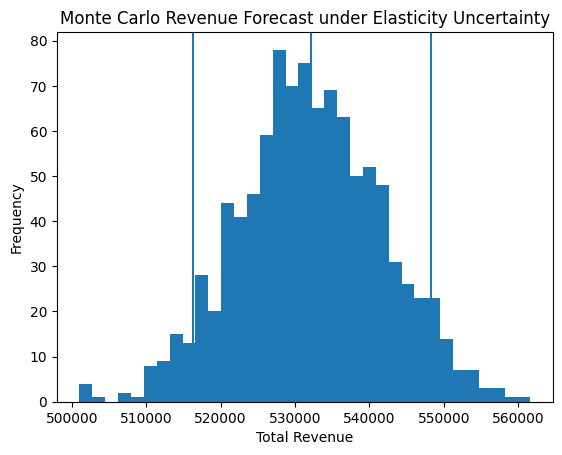

In [11]:
plt.figure()
plt.hist(sim_results, bins=35)
plt.axvline(np.mean(sim_results))
plt.axvline(np.percentile(sim_results,5))
plt.axvline(np.percentile(sim_results,95))
plt.title("Monte Carlo Revenue Forecast under Elasticity Uncertainty")
plt.xlabel("Total Revenue")
plt.ylabel("Frequency")
plt.savefig("revenue_uncertainty_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


In [12]:
def policy_scenario(df, price_change=0.10):
    df2 = df.copy()
    df2["Scenario Price"] = df2["Baseline Price P0"] * (1+price_change)
    df2["Scenario Revenue"] = df2.apply(
        lambda r: revenue(r["a"],r["b"],r["Scenario Price"]), axis=1)
    return df2["Scenario Revenue"].sum()

for p in [-0.1,0.05,0.1,0.2]:
    print(f"{int(p*100)}% price change → ${policy_scenario(df,p):,.0f}")


-10% price change → $447,051
5% price change → $484,305
10% price change → $494,358
20% price change → $510,916


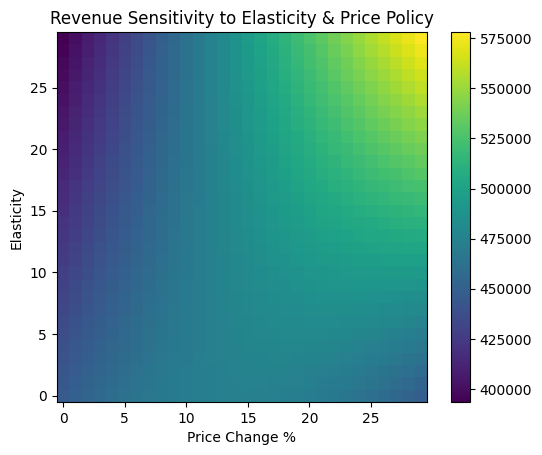

In [13]:
import numpy as np
import matplotlib.pyplot as plt

price_grid = np.linspace(-0.2,0.3,30)
elasticity_grid = np.linspace(-0.9,-0.2,30)

Z = np.zeros((30,30))

for i,p in enumerate(price_grid):
    for j,e in enumerate(elasticity_grid):
        temp = df.copy()
        temp["Elasticity Sim"] = e
        temp["b"] = -e*(temp["Baseline Qty Q0"]/temp["Baseline Price P0"])
        temp["a"] = temp["Baseline Qty Q0"] + temp["b"]*temp["Baseline Price P0"]
        temp["Rev"] = temp.apply(lambda r: revenue(r["a"],r["b"],r["Baseline Price P0"]*(1+p)),axis=1)
        Z[j,i] = temp["Rev"].sum()

plt.imshow(Z,origin='lower')
plt.title("Revenue Sensitivity to Elasticity & Price Policy")
plt.xlabel("Price Change %")
plt.ylabel("Elasticity")
plt.colorbar()
plt.savefig("policy_sensitivity_heatmap.png",dpi=200)
plt.show()
